# SAE-96 - Nettoyage Dataset Business

**Objectif:** Charger, analyser et nettoyer le dataset Business de Yelp

**Input:** `data/raw/yelp_academic_dataset_business.json`

**Output:** `data/cleaned/business_clean.parquet`

---

## 1. Imports et Configuration

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("✅ Imports réussis")

✅ Imports réussis


## 2. Chargement des Données

In [3]:
# Chemins
RAW_DATA_PATH = Path('../data/raw/yelp_academic_dataset_business.json')
CLEANED_DATA_PATH = Path('../data/cleaned/business_clean.parquet')

# Créer le dossier cleaned s'il n'existe pas
CLEANED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"📂 Chargement depuis: {RAW_DATA_PATH}")
print(f"💾 Sauvegarde vers: {CLEANED_DATA_PATH}")

📂 Chargement depuis: ..\data\raw\yelp_academic_dataset_business.json
💾 Sauvegarde vers: ..\data\cleaned\business_clean.parquet


In [4]:
# Chargement du fichier JSON (format JSON Lines)
business_df = pd.read_json(RAW_DATA_PATH, lines=True)

print(f"✅ Données chargées: {business_df.shape[0]:,} lignes, {business_df.shape[1]} colonnes")
print(f"📊 Taille mémoire: {business_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Données chargées: 150,346 lignes, 14 colonnes
📊 Taille mémoire: 108.25 MB


## 3. Exploration Initiale

In [5]:
# Aperçu des données
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [6]:
# Informations sur les colonnes
business_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  str    
 1   name          150346 non-null  str    
 2   address       150346 non-null  str    
 3   city          150346 non-null  str    
 4   state         150346 non-null  str    
 5   postal_code   150346 non-null  str    
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  str    
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(2), str(7)
memory usage: 35.4+ MB


In [7]:
# Statistiques descriptives
business_df.describe()

,latitude,longitude,stars,review_count,is_open
count,150346.000000,150346.000000,150346.000000,150346.000000,150346.00000
mean,36.671150,-89.357339,3.596724,44.866561,0.79615
std,5.872759,14.918502,0.974421,121.120136,0.40286
min,27.555127,-120.095137,1.000000,5.000000,0.00000
25%,32.187293,-90.357810,3.000000,8.000000,1.00000
50%,38.777413,-86.121179,3.500000,15.000000,1.00000
75%,39.954036,-75.421542,4.500000,37.000000,1.00000
max,53.679197,-73.200457,5.000000,7568.000000,1.00000


## 4. Analyse des Valeurs Manquantes

In [8]:
# Calcul des valeurs manquantes
missing_data = pd.DataFrame({
    'Colonne': business_df.columns,
    'Valeurs_Manquantes': business_df.isnull().sum(),
    'Pourcentage': (business_df.isnull().sum() / len(business_df) * 100).round(2)
}).sort_values('Pourcentage', ascending=False)

print("📊 Valeurs manquantes par colonne:")
missing_data[missing_data['Valeurs_Manquantes'] > 0]

📊 Valeurs manquantes par colonne:


,Colonne,Valeurs_Manquantes,Pourcentage
hours,hours,23223,15.45
attributes,attributes,13744,9.14
categories,categories,103,0.07


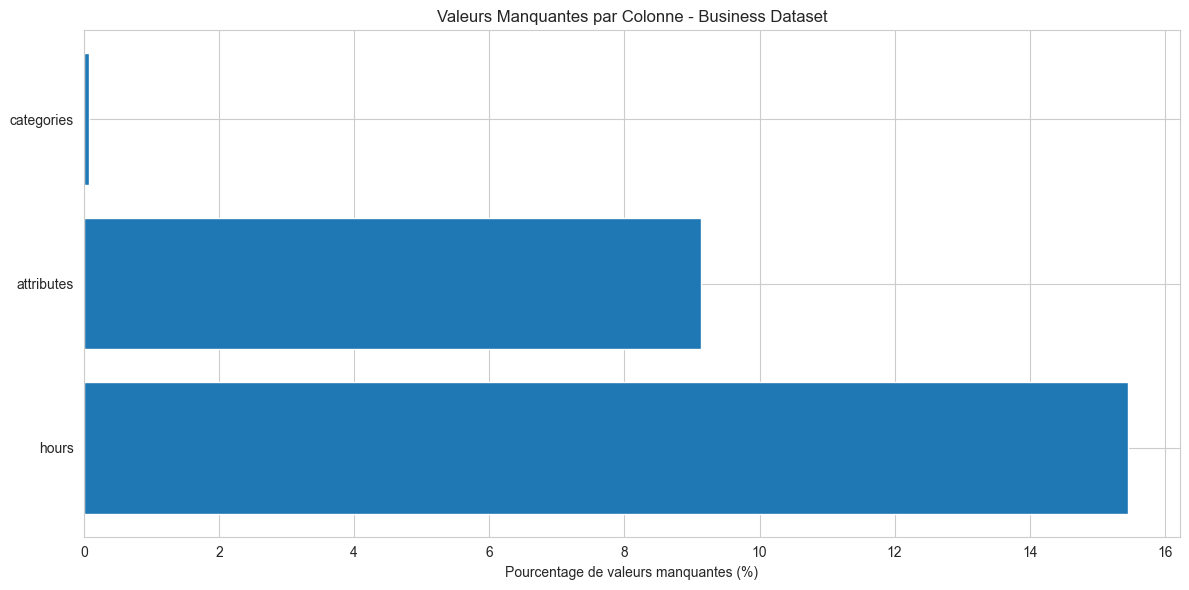

In [9]:
# Visualisation des valeurs manquantes
plt.figure(figsize=(12, 6))
missing_cols = missing_data[missing_data['Valeurs_Manquantes'] > 0]
if len(missing_cols) > 0:
    plt.barh(missing_cols['Colonne'], missing_cols['Pourcentage'])
    plt.xlabel('Pourcentage de valeurs manquantes (%)')
    plt.title('Valeurs Manquantes par Colonne - Business Dataset')
    plt.tight_layout()
    plt.show()
else:
    print("✅ Aucune valeur manquante détectée!")

## 5. Nettoyage des Données

In [10]:
# Copie pour le nettoyage
business_clean = business_df.copy()

print(f"📋 Dataset initial: {len(business_clean):,} lignes")

📋 Dataset initial: 150,346 lignes


### 5.1 Suppression des Doublons

In [11]:
# Vérifier les doublons sur business_id
duplicates = business_clean.duplicated(subset=['business_id'], keep=False)
print(f"🔍 Doublons trouvés: {duplicates.sum()}")

if duplicates.sum() > 0:
    business_clean = business_clean.drop_duplicates(subset=['business_id'], keep='first')
    print(f"✅ Doublons supprimés. Nouvelles lignes: {len(business_clean):,}")
else:
    print("✅ Aucun doublon détecté")

🔍 Doublons trouvés: 0
✅ Aucun doublon détecté


### 5.2 Traitement des Valeurs Manquantes

In [12]:
# Supprimer les lignes sans business_id (clé primaire)
if business_clean['business_id'].isnull().any():
    before = len(business_clean)
    business_clean = business_clean.dropna(subset=['business_id'])
    print(f"❌ Supprimé {before - len(business_clean)} lignes sans business_id")

# Supprimer les lignes sans nom
if business_clean['name'].isnull().any():
    before = len(business_clean)
    business_clean = business_clean.dropna(subset=['name'])
    print(f"❌ Supprimé {before - len(business_clean)} lignes sans nom")

print(f"\n📊 Dataset après nettoyage: {len(business_clean):,} lignes")


📊 Dataset après nettoyage: 150,346 lignes


### 5.3 Nettoyage des Colonnes Spécifiques

In [13]:
# Remplir les valeurs manquantes pour les colonnes numériques
if 'stars' in business_clean.columns:
    business_clean['stars'] = business_clean['stars'].fillna(business_clean['stars'].median())

if 'review_count' in business_clean.columns:
    business_clean['review_count'] = business_clean['review_count'].fillna(0)

# Remplir les valeurs manquantes pour les colonnes textuelles
text_columns = ['city', 'state', 'postal_code', 'address']
for col in text_columns:
    if col in business_clean.columns:
        business_clean[col] = business_clean[col].fillna('Unknown')

print("✅ Valeurs manquantes traitées")

✅ Valeurs manquantes traitées


### 5.4 Validation des Données

In [14]:
# Vérifier que stars est entre 0 et 5
if 'stars' in business_clean.columns:
    invalid_stars = business_clean[(business_clean['stars'] < 0) | (business_clean['stars'] > 5)]
    if len(invalid_stars) > 0:
        print(f"⚠️ {len(invalid_stars)} lignes avec stars invalides")
        business_clean = business_clean[(business_clean['stars'] >= 0) & (business_clean['stars'] <= 5)]
    else:
        print("✅ Toutes les notes sont valides (0-5)")

# Vérifier que review_count est positif
if 'review_count' in business_clean.columns:
    invalid_reviews = business_clean[business_clean['review_count'] < 0]
    if len(invalid_reviews) > 0:
        print(f"⚠️ {len(invalid_reviews)} lignes avec review_count négatif")
        business_clean = business_clean[business_clean['review_count'] >= 0]
    else:
        print("✅ Tous les review_count sont valides (≥0)")

✅ Toutes les notes sont valides (0-5)
✅ Tous les review_count sont valides (≥0)


## 6. Statistiques Finales

In [15]:
print("📊 RÉSUMÉ DU NETTOYAGE")
print("=" * 50)
print(f"Lignes initiales:     {len(business_df):,}")
print(f"Lignes finales:       {len(business_clean):,}")
print(f"Lignes supprimées:    {len(business_df) - len(business_clean):,}")
print(f"Pourcentage conservé: {(len(business_clean) / len(business_df) * 100):.2f}%")
print("=" * 50)

📊 RÉSUMÉ DU NETTOYAGE
Lignes initiales:     150,346
Lignes finales:       150,346
Lignes supprimées:    0
Pourcentage conservé: 100.00%


In [16]:
# Vérification finale des valeurs manquantes
final_missing = business_clean.isnull().sum()
if final_missing.sum() > 0:
    print("\n⚠️ Valeurs manquantes restantes:")
    print(final_missing[final_missing > 0])
else:
    print("\n✅ Aucune valeur manquante dans le dataset nettoyé!")


⚠️ Valeurs manquantes restantes:
attributes    13744
categories      103
hours         23223
dtype: int64


## 7. Visualisations

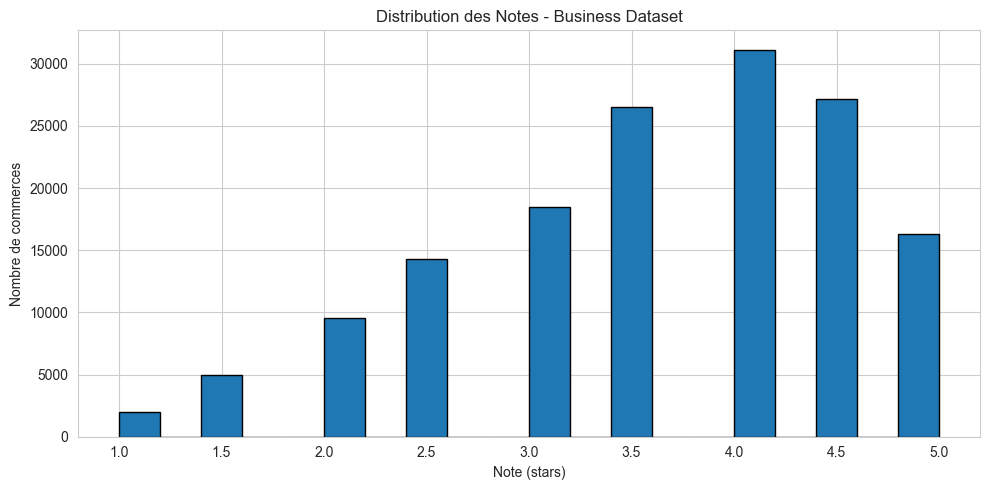

In [17]:
# Distribution des notes
if 'stars' in business_clean.columns:
    plt.figure(figsize=(10, 5))
    business_clean['stars'].hist(bins=20, edgecolor='black')
    plt.xlabel('Note (stars)')
    plt.ylabel('Nombre de commerces')
    plt.title('Distribution des Notes - Business Dataset')
    plt.tight_layout()
    plt.show()

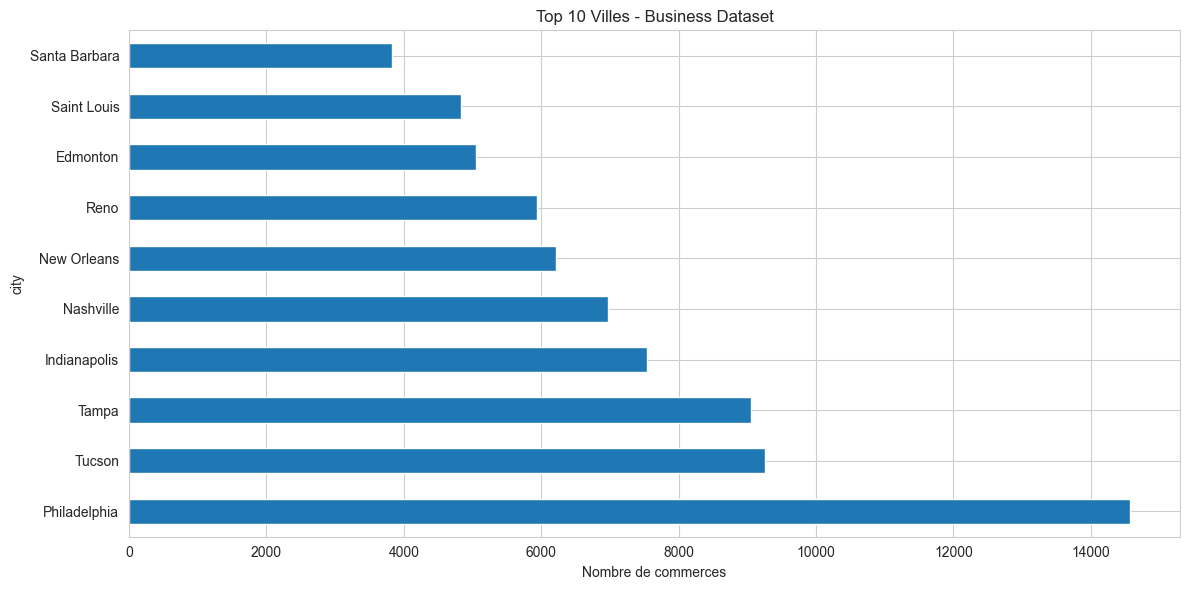

In [18]:
# Top 10 villes
if 'city' in business_clean.columns:
    plt.figure(figsize=(12, 6))
    top_cities = business_clean['city'].value_counts().head(10)
    top_cities.plot(kind='barh')
    plt.xlabel('Nombre de commerces')
    plt.title('Top 10 Villes - Business Dataset')
    plt.tight_layout()
    plt.show()

## 8. Sauvegarde des Données Nettoyées

In [19]:
# Sauvegarde en format Parquet (plus efficace que CSV)
business_clean.to_parquet(CLEANED_DATA_PATH, index=False, compression='snappy')

print(f"✅ Données sauvegardées: {CLEANED_DATA_PATH}")
print(f"📊 Taille du fichier: {CLEANED_DATA_PATH.stat().st_size / 1024**2:.2f} MB")

✅ Données sauvegardées: ..\data\cleaned\business_clean.parquet
📊 Taille du fichier: 17.30 MB


In [20]:
# Test de rechargement
test_df = pd.read_parquet(CLEANED_DATA_PATH)
print(f"\n✅ Test de rechargement réussi: {len(test_df):,} lignes")
print(f"📋 Colonnes: {list(test_df.columns)}")


✅ Test de rechargement réussi: 150,346 lignes
📋 Colonnes: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


---

## ✅ SAE-96 Terminé

**Résultat:** Dataset Business nettoyé et sauvegardé en format Parquet

**Prochaines étapes:**
- SAE-97: Nettoyage Reviews
- SAE-98: Nettoyage Users
- SAE-67: Dashboard Profils Reviewers